In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import time
import pickle
import csv

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from feature_extraction import *
from img_processing import *

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### SVM Classifier

In [3]:
# Read in cars and notcars
notcars = glob.glob('../imgs/non-vehicles/*/*.png', recursive=True)
cars = glob.glob('../imgs/vehicles/*/*.png', recursive=True)

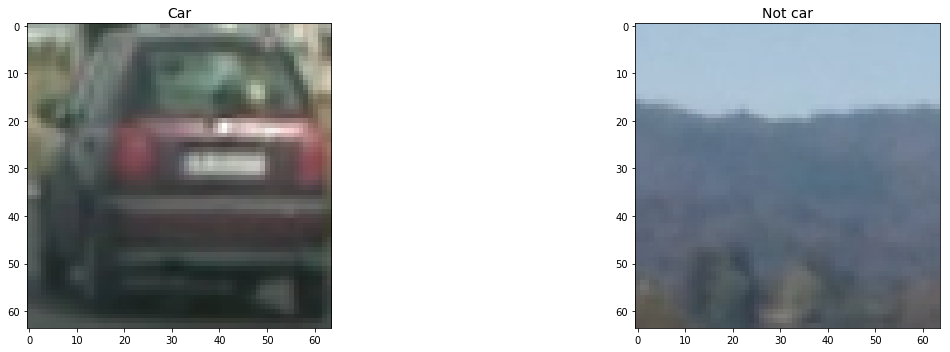

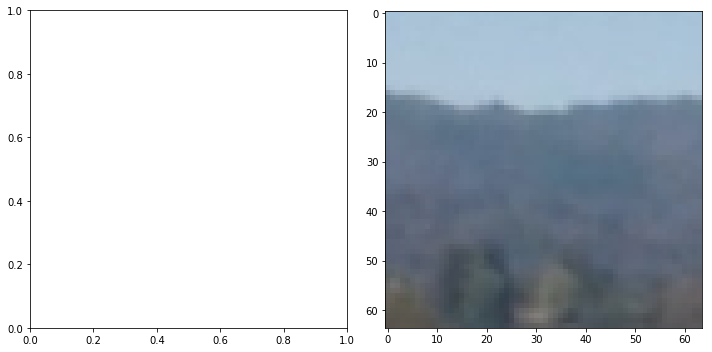

In [10]:
image_car = cv2.cvtColor(cv2.imread(cars[np.random.randint(0, len(cars))]), cv2.COLOR_BGR2RGB)
image_ncar = cv2.cvtColor(cv2.imread(notcars[np.random.randint(0, len(notcars))]), cv2.COLOR_BGR2RGB)

plot_many([image_car, image_ncar], name='../report_images/car_notcar.jpg', title=['Car', 'Not car'])

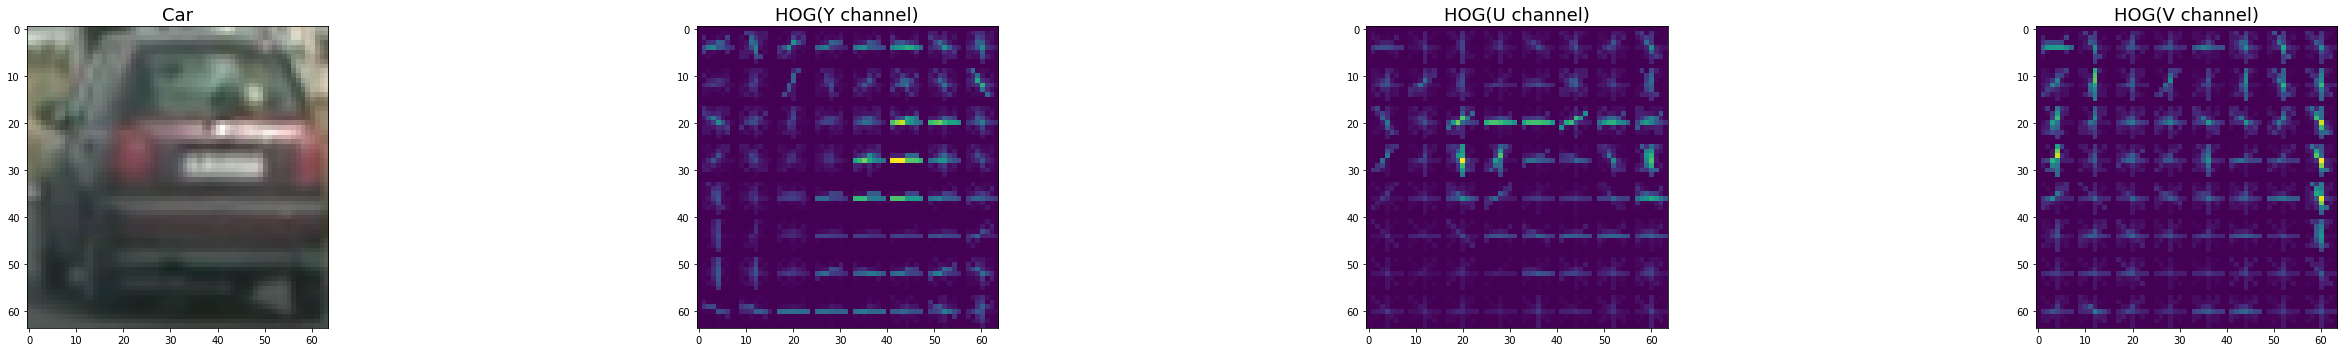

In [15]:
hog_feat_y, hog_img_y = get_hog_features(img=rgb2yuv(image_car, ch=0), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_feat_u, hog_img_u = get_hog_features(img=rgb2yuv(image_car, ch=1), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_feat_v, hog_img_v = get_hog_features(img=rgb2yuv(image_car, ch=2), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
#plot_many([image_car, rgb2yuv(image_car)], name='../report_images/car_hog0.jpg', title=['Car', 'YUV'])
plot_many([image_car, hog_img_y, hog_img_u, hog_img_v], name='../report_images/car_hog1.jpg', title=['Car', 'HOG(Y channel)', 'HOG(U channel)', 'HOG(V channel)'], fontsize=18)
#plot_many([rgb2yuv(image_car, ch=1), hog_img_u], name='../report_images/car_hog2.jpg', title=['Car U', 'HOG(U channel)'])
#plot_many([rgb2yuv(image_car, ch=2), hog_img_v], name='../report_images/car_hog3.jpg', title=['Car V', 'HOG(V channel)'])

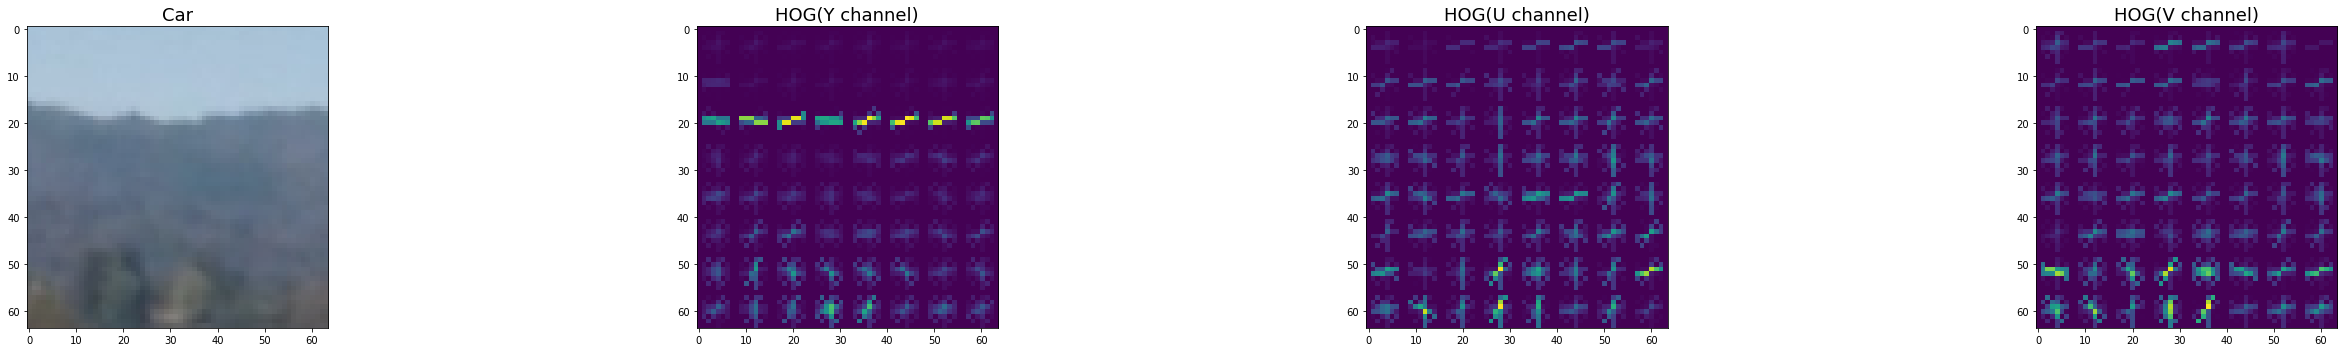

In [16]:
hog_feat_y, hog_img_y = get_hog_features(img=rgb2yuv(image_ncar, ch=0), orient = 9, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_feat_u, hog_img_u = get_hog_features(img=rgb2yuv(image_ncar, ch=1), orient = 9, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_feat_v, hog_img_v = get_hog_features(img=rgb2yuv(image_ncar, ch=2), orient = 9, pix_per_cell = 8, cell_per_block = 2, vis=True)
#plot_many([image_ncar, rgb2yuv(image_ncar)], name='../report_images/car_nhog0.jpg', title=['Not car', 'YUV'])
plot_many([image_ncar, hog_img_y, hog_img_u, hog_img_v], name='../report_images/car_nhog1.jpg', title=['Car', 'HOG(Y channel)', 'HOG(U channel)', 'HOG(V channel)'], fontsize=18)
#plot_many([rgb2yuv(image_ncar, ch=1), hog_img_u], name='../report_images/car_nhog2.jpg', title=['Not car U', 'HOG(U channel)'])
#plot_many([rgb2yuv(image_ncar, ch=2), hog_img_v], name='../report_images/car_nhog3.jpg', title=['Not car V', 'HOG(V channel)'])

In [ ]:
params = {'color_space': 'YUV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
          'orient': 9, # HOG orientations
          'pix_per_cell': 8, # HOG pixels per cell
          'cell_per_block': 2, # HOG cells per block
          'hog_channel': 'ALL', # Can be 0, 1, 2, or "ALL"
          'spatial_size': (32, 32), # Spatial binning dimensions
          'hist_bins': 32, # Number of histogram bins
          'spatial_feat': True, # Spatial features on or off
          'hist_feat': True, # Histogram features on or off
          'hog_feat': True # HOG features on or off
         } 

car_features = extract_features(cars, **params)
notcar_features = extract_features(notcars, **params)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, shuffle = True, random_state=rand_state)

print('Using:',params['orient'],'orientations', params['pix_per_cell'],
    'pixels per cell and', params['cell_per_block'],'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

In [ ]:
# save classifier into a pickle file
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["params"] = params
dist_pickle["scaler"] = X_scaler
pickle.dump(dist_pickle, open( "../classifier_data/svc_pickle2.p", "wb" ) )
print('Classifier is stored to the pickle file under ../classifier_data/')

### Car Detector

In [21]:
# load classifier data
dist_pickle = pickle.load( open("../classifier_data/svc_pickle2.p", "rb" ) )
svc = dist_pickle["svc"]
params = dist_pickle["params"]
X_scaler = dist_pickle["scaler"]
print('Classifier data is loaded')

Classifier data is loaded


In [ ]:
# test
image = cv2.imread('../test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

y_start_stop = [400, 650]
windows = slide_window(image, 
                       x_start_stop=[None, None], 
                       y_start_stop=y_start_stop, 
                       xy_window=(96, 96), 
                       xy_overlap=(0.5, 0.5)
                      )

hot_windows = search_windows(image, windows, svc, X_scaler, **params)                       

window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6) 

plt.figure(figsize=(20, 10))
plt.imshow(window_img)
plt.show()

In [ ]:
# For report
params = {'color_space': 'YUV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
          'orient': 9, # HOG orientations
          'pix_per_cell': 8, # HOG pixels per cell
          'cell_per_block': 2, # HOG cells per block
          'hog_channel': 'ALL', # Can be 0, 1, 2, or "ALL"
          'spatial_size': (32, 32), # Spatial binning dimensions
          'hist_bins': 32, # Number of histogram bins
          'spatial_feat': False, # Spatial features on or off
          'hist_feat': False, # Histogram features on or off
          'hog_feat': True # HOG features on or off
         } 

image = cv2.imread('../test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart=400, ystop=650, scale=1.5, svc=svc, X_scaler=X_scaler, 
              color_space = 'YUV', orient = 9, pix_per_cell = 8, cell_per_block = 2, spatial_size = (32, 32), hist_bins = 32, hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True):
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1 
    print("Blocks in x axis: {}".format(nxblocks))
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    print("Blocks in y axis: {}".format(nyblocks))
    nfeat_per_block = orient*cell_per_block**2 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #print("Blocks per window: {}".format(nblocks_per_window))
    cells_per_step_x = 2  # Instead of overlap, define how many cells to step
    cells_per_step_y = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step_x
    #print("Steps in x axis: {}".format(nxsteps))
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step_y
    print("Steps in y axis: {}".format(nysteps))
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step_y
            xpos = xb*cells_per_step_x
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_features = X_scaler.transform((hog_features).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            #if test_prediction == 1:
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            box = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
            box_list.append(box)
            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

    #heat = np.zeros_like(img[:,:,0]).astype(np.float)
    #heat_m = add_heat(heat, box_list)    
    #labels = label(heat_m)
    #draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img
 
ystart = 400
ystop = 500
scale = 1

out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, **params)
plot(out_img, size=(10, 5), name='../report_images/400_500_1.jpg')

ystart = 400
ystop = 550
scale = 1.3

out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, **params)
plot(out_img, size=(10, 5), name='../report_images/400_550_1_3.jpg')

ystart = 400
ystop = 600
scale = 1.7

out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, **params)
plot(out_img, size=(10, 5), name='../report_images/400_600_1_7.jpg')

ystart = 450
ystop = 700
scale = 2.5

out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, **params)
plot(out_img, size=(10, 5), name='../report_images/450_700_2_5.jpg')

In [22]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_v2(img, ystart=400, ystop=650, xstart=0, xstop=1280, scale=1.5, cells_per_step=2, svc=svc, X_scaler=X_scaler, 
              color_space = 'YUV', orient = 9, pix_per_cell = 8, cell_per_block = 2, spatial_size = (64, 64), hist_bins = 32, hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True):
    
    global heat_m 
    
    draw_img = np.copy(img)    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1 
    #print("Blocks in x axis: {}".format(nxblocks))
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    #print("Blocks in y axis: {}".format(nyblocks))
    nfeat_per_block = orient*cell_per_block**2 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #print("Blocks per window: {}".format(nblocks_per_window))
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    #print("Steps in x axis: {}".format(nxsteps))
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    #print("Steps in y axis: {}".format(nysteps))
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))   
            #test_features = X_scaler.transform((hog_features).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = xstart + np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                boxes.append(box)
    
    return boxes

In [23]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), 
                (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def draw_labeled_bboxes_v2(img, labels, hist_conv_x, hist_conv_y):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Find height and width of the box
        h = np.max(nonzeroy) - np.min(nonzeroy)
        w = np.max(nonzerox) - np.min(nonzerox)
        # Find center of the bounding box
        cx = np.min(nonzerox) + np.argmax(hist_conv_x[np.min(nonzerox):np.max(nonzerox)])   
        #cy = np.min(nonzeroy) + np.argmax(hist_conv_y[np.min(nonzeroy)-400:np.max(nonzeroy)-400])
        # Define a bounding box
        bbox = ((np.uint32(np.clip(cx - w/2, 0, 1280)), np.min(nonzeroy)), 
                (np.uint32(np.clip(cx + w/2, 0, 1280)), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def plot2nparray(vector, my_dpi=96, points=None): 
    fig = plt.figure(figsize=(300/my_dpi, 168/my_dpi), dpi=my_dpi)
    ax = fig.add_subplot(111)
    ax.plot(vector)
    if type(points) is np.ndarray:
        ax.plot(points, vector[points], 'r')
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()
    return data

def add_pics(img, info_pics):
    img_size = (img.shape[1], img.shape[0])
    info_size = 300
    r = float(info_size / img_size[0])
    dim = (info_size, int(img_size[1] * r))
    
    x_offset=y_offset=1
    img_cp = np.copy(img)
    
    if len(info_pics) == 1:
        info = cv2.resize(info_pics[0], dim)
        cv2.rectangle(img_cp, (0, 0), (info_size + 2, int(img_size[1] * r + 2)), (0,255,0), thickness = 1, lineType = cv2.LINE_AA)
        img_cp[y_offset:y_offset+info.shape[0], x_offset:x_offset+info.shape[1]] = info
    else:
        for pic in info_pics:
            info = cv2.resize(pic, dim)
            #cv2.rectangle(img_cp, (0, 0), (info_size + 2, int(img_size[1] * r + 2)), (0,255,0), thickness = 1, lineType = cv2.LINE_AA)
            img_cp[y_offset:y_offset+info.shape[0], x_offset:x_offset+info.shape[1]] = info
            x_offset += dim[0]
            #y_offset += dim[1]
    return img_cp

def sobel_abs(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [43]:
heat_m = np.zeros(shape=(720, 1280)).astype(np.int8)

vertices = np.int32([[0, 720], [575, 450], [705, 450], [1280, 720]])

def pipeline(image):
    global heat_m
    
    boxes = []
    
    xstart = 0
    xstop = 1280
    cells_per_step = 2
    
    scale = 1
    ystart = 400
    ystop = 500
    boxes1 = find_cars_v2(image, ystart, ystop, xstart, xstop, scale, cells_per_step, svc, X_scaler, **params)
    boxes.extend(boxes1)
    
    scale = 1.3
    ystart = 400
    ystop = 550
    boxes1_3 = find_cars_v2(image, ystart, ystop, xstart, xstop, scale, cells_per_step, svc, X_scaler, **params)
    boxes.extend(boxes1_3)
    
    scale = 1.7
    ystart = 400
    ystop = 600
    boxes1_7 = find_cars_v2(image, ystart, ystop, xstart, xstop, scale, cells_per_step, svc, X_scaler, **params)
    boxes.extend(boxes1_7)
    
    scale = 2.5
    ystart = 450
    ystop = 700
    boxes2_5 = find_cars_v2(image, ystart, ystop, xstart, xstop, scale, cells_per_step, svc, X_scaler, **params)
    boxes.extend(boxes2_5)
    
    """draw_boxes = np.copy(image)
    for box in boxes:
        cv2.rectangle(draw_boxes,box[0],box[1],(0,0,255),6) """

    heat = np.zeros_like(image[:,:,0]).astype(np.int8)
    
    if not np.any(heat_m):
        heat_m = add_heat(heat, list(boxes))
    else:
        heat_m = np.uint8(0.7*add_heat(heat, list(boxes)) + (1-0.7)*heat_m)
    
    """heat_show = np.copy(heat_m)"""
    
    heatmap = apply_threshold(heat_m, 1)
    
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    #info3 = np.uint8(np.clip(np.dstack((heatmap, heatmap, heatmap))*5, 0, 255))
    
    #result = add_pics(draw_img, info_pics=[info3])
    return draw_img

In [44]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [19:11<00:00,  1.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 19min 57s, sys: 4.84 s, total: 20min 2s
Wall time: 19min 13s


In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
# Extract frames from video
import os
from moviepy.editor import *

def extract_frames(movie, times, imgdir):
    clip = VideoFileClip(movie)
    for t in times:
        name = str(t).replace('.', '_') + '.png'
        imgpath = os.path.join(imgdir, name)
        clip.save_frame(imgpath, t)

movie = "../project_video.mp4"
imgdir = "../test_images/"
times = 4, 4.5, 5, 5.5, 6, 6.5, 7, 8, 9, 10, 26, 26.5, 27, 27.5, 28, 28.5, 29, 30

extract_frames(movie, times, imgdir)

In [ ]:
test_names = glob.glob('../test_images/*.png')
test_set = []
for name in test_names:
    test_set.append(cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB))
test_set = np.array(test_set)

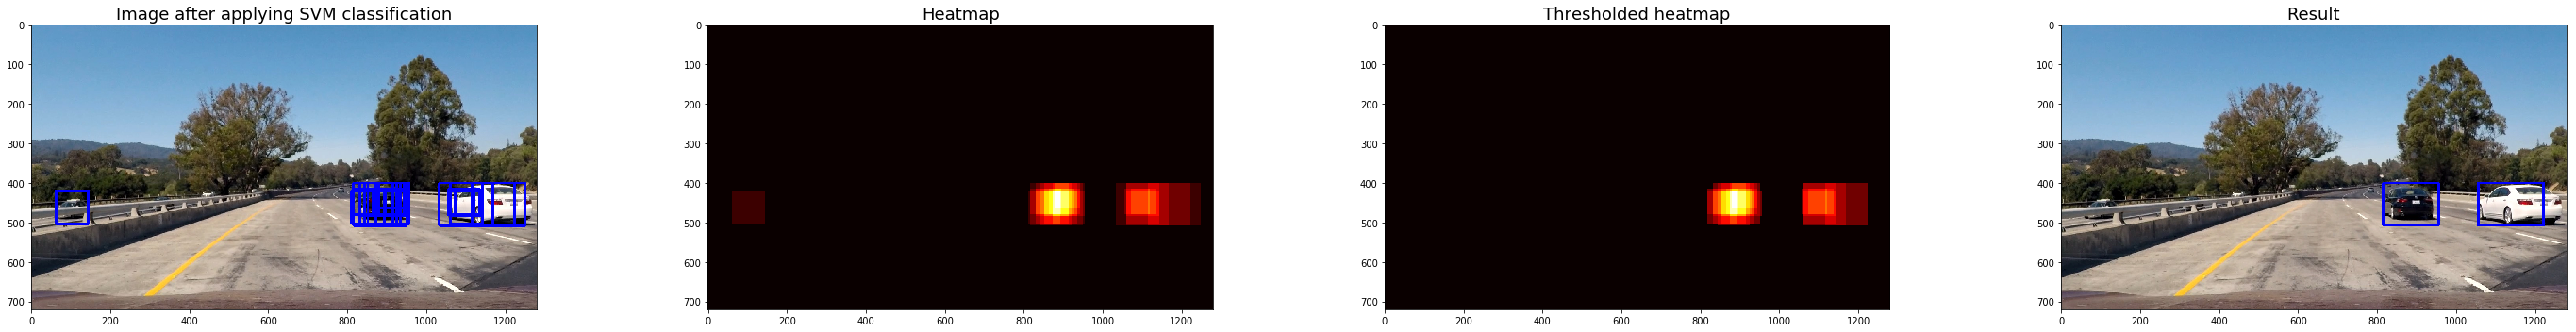

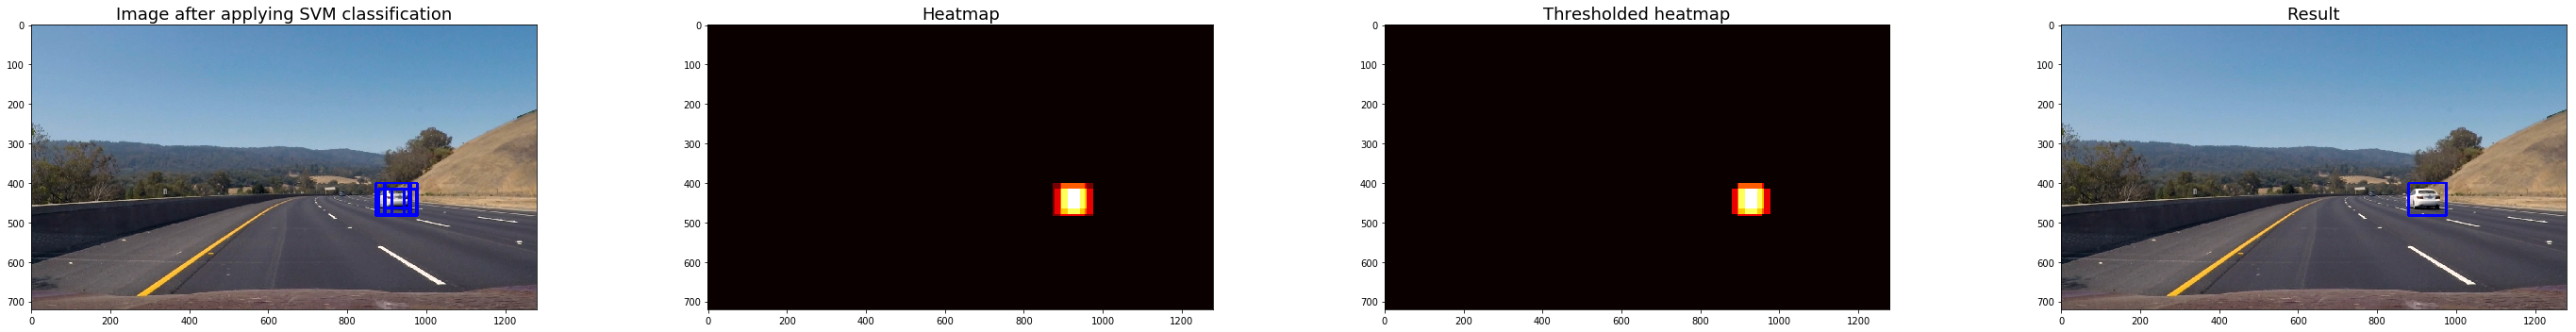

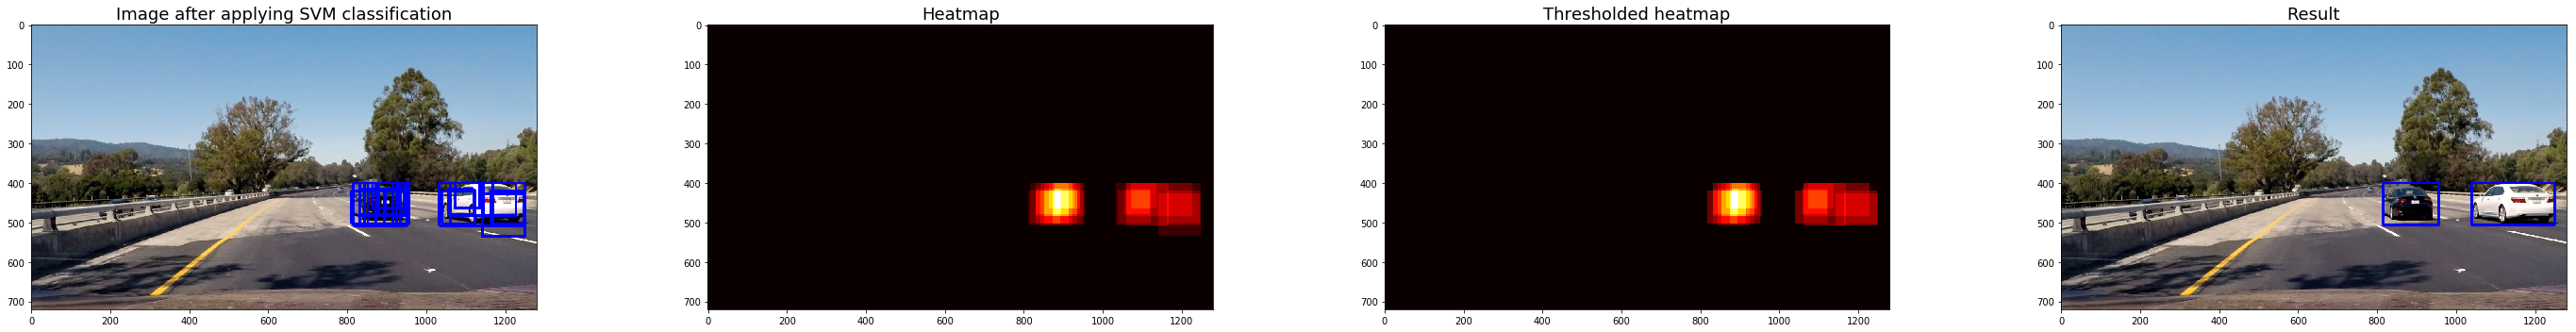

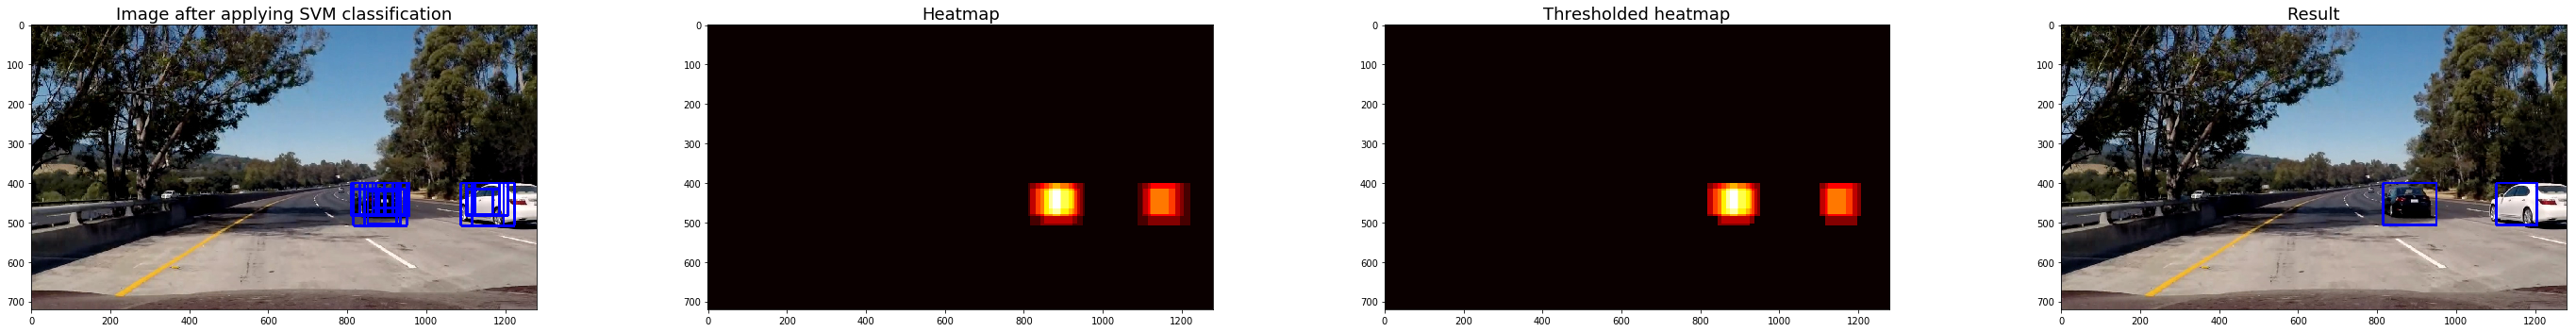

In [30]:
# For report
test_names = ['../test_images/test1.jpg', '../test_images/test3.jpg', '../test_images/test4.jpg', '../test_images/test5.jpg']
test_set = []
for name in test_names:
    test_set.append(cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB))
test_set = np.array(test_set)

for i, test_sample in enumerate(test_set):
    res, raw_boxes, raw_heat, heat = pipeline(test_sample)
    plot_many([raw_boxes, raw_heat, heat, res], 
              cmaps=[None, 'hot', 'hot', None], 
              name='../report_images/pipeline' + str(i) + '.jpg', 
              title=['Image after applying SVM classification', 'Heatmap', 'Thresholded heatmap', 'Result'], fontsize=18)

In [ ]:
test_names = ['../test_images/4.png', '../test_images/4_5.png', '../test_images/5.png', '../test_images/5_5.png', '../test_images/6.png', '../test_images/6_5.png', '../test_images/7.png', '../test_images/8.png',
             '../test_images/26.png', '../test_images/26_5.png', '../test_images/27.png', '../test_images/27_5.png']
test_set = []
for name in test_names:
    test_set.append(cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB))
test_set = np.array(test_set)

for test_sample in test_set:
    
    combined = np.zeros_like(test_sample[:,:,0])
    combined[(channel_thresholding(rgb2lab(test_sample), ch=2, thresh=(150, 255)) == 1) |
             (white_select(rgb2hls(test_sample)) == 1) |
             (sobel_abs(rgb2gray(test_sample), thresh=(30, 100)) == 1)] = 255
    roi = region_of_interest(combined, vertices)
    
    ret,thresh1 = cv2.threshold(rgb2hls(test_sample)[:,:,2],160,255,cv2.THRESH_BINARY)

    plot_many([test_sample, video_filter(test_sample)])